In [1]:
import os
import re
import pickle
from itertools import product
from collections import Counter
import random
import matplotlib.pyplot as plt
import spacy
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Lexical_simp'

Mounted at /content/drive
/content/drive/MyDrive/Lexical_simp


#Prepare data


In [2]:
%cd '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/'
!pip install imohash
from muss.utils.helpers import read_lines
### Encode the complex sentence 


def encode_complex(sentence,NER):
  def list_duplicates_of(seq,item):
    start_at = -1
    locs = []
    while True:
        try:
            loc = seq.index(item,start_at+1)
        except ValueError:
            break
        else:
            locs.append(loc)
            start_at = loc
    return locs
  tag_sen = sentence
  tag = ' <POS_>'
  for ner in NER:
    if ner == '':
      pass
    else:
      
      index = list_duplicates_of(tag_sen,ner)
      # print(index)
      for i, idx in enumerate(index):
        # print(idx)
        # print(tag_sen)
        # print(ner)
        tag_sen = tag_sen[0:idx] + '<POS_> ' + ner + ' <_POS>' + tag_sen[idx+len(ner):]
        # print(tag_sen)
        # print('-'*30)
        try:
          index[i+1] += 2*len(tag)
        except:
          pass
      
  # tag_sen = ' <NEXT_NE> '+' <NEXT_NE> '.join(NER) + " <SENT_START> " + tag_sen
  return tag_sen

/content/drive/MyDrive/Baseline_MUSS_corrupt/muss
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.6 MB/s 
  Created wheel for varint: filename=varint-1.0.2-py3-none-any.whl size=1980 sha256=cf5cadb681650b863094b4e60da7488e7f0b2c5f1ad1c3fc138b5f9f4de47cee
  Stored in directory: /root/.cache/pip/wheels/69/21/07/09f1c6a7d9b59377aa6d98da6efdd670f7ca40aabd93d02704
Successfully built varint


data loading


In [3]:
PHASES = ['train','valid','test']
LANGUAGES = ['complex']
data_names = []


for phase, language in product(PHASES, LANGUAGES):

  data_name = phase + '_' + language
  data_names.append(data_name)

data_names

['train_complex', 'valid_complex', 'test_complex']

In [4]:
with open('/content/drive/MyDrive/Lexical_simp/lexical_train_wiki_filtered.pkl','rb') as f:
  # a = [ls_result,ls_replacement]
  data = pickle.load(f)
ls_result, ls_replacement = data[0],data[1]

### NE_recovery_prefix_all

In [5]:
input = [i[1] for i in ls_result]
input[:10]
# ls_replacement[:100]

['There is manuscript support that Austen continued to work on these pieces as late as the period 1809 â "11',
 'In a remarkable comparative study',
 'Before Persephone was released to Hermes',
 'Plays and comic puppet theater loosely based on this story were popular throughout Germany in the 16th century',
 'In September 1869',
 'The Algerian government cut the power supply to at least large parts of the capital city (and also to large parts of the country)',
 'Sensing of both the external and internal world at the cellular level depends on information production Many health processes',
 'A very wide covered bridge joins all platforms at their western ends but does not provide entry to or egress from the station.',
 'Its widespread location in many leaves and plants may serve to encourage the nervous tract into eating the leaves.',
 'Free content']

In [6]:
train_input = []
train_target = []
for i,j in enumerate(input):
  if ls_replacement[i] is not None:
    NER = [k[0] for k in ls_replacement[i] if k is not None]
    # print(NER)
    if NER:
      sentence_w_control_token = ' <NEXT_NE> '+' <NEXT_NE> '.join(NER) + " <SENT_START> " + j
      train_input.append(sentence_w_control_token)
      train_target.append(ls_result[i][0])
    else:
      pass
  else:
    pass
train_input[:10]

[' <NEXT_NE> evidence <SENT_START> There is manuscript support that Austen continued to work on these pieces as late as the period 1809 â "11',
 ' <NEXT_NE> analysis <SENT_START> In a remarkable comparative study',
 ' <NEXT_NE> legend <SENT_START> Plays and comic puppet theater loosely based on this story were popular throughout Germany in the 16th century',
 ' <NEXT_NE> electricity <NEXT_NE> Algiers <NEXT_NE> allegedly <SENT_START> The Algerian government cut the power supply to at least large parts of the capital city (and also to large parts of the country)',
 ' <NEXT_NE> environments <NEXT_NE> relies <NEXT_NE> signal <NEXT_NE> transduction. <NEXT_NE> disease <SENT_START> Sensing of both the external and internal world at the cellular level depends on information production Many health processes',
 ' <NEXT_NE> footbridge <SENT_START> A very wide covered bridge joins all platforms at their western ends but does not provide entry to or egress from the station.',
 ' <NEXT_NE> presence 

In [7]:
len(train_input) == len(train_target)
train_target[:10]

['There is manuscript evidence that Austen continued to work on these pieces as late as the period 1809 â "11',
 'In a remarkable comparative analysis',
 'Plays and comic puppet theater loosely based on this legend were popular throughout Germany in the 16th century',
 'The Algerian government cut the electricity supply to at least large parts of the capital Algiers (and allegedly to large parts of the country)',
 'Sensing of both the external and internal environments at the cellular level relies on signal transduction. Many disease processes',
 'A very wide covered footbridge joins all platforms at their western ends but does not provide entry to or egress from the station.',
 'Its widespread presence in many seeds and fruits may serve to stimulate the digestive tract into expelling the seeds.',
 "They take up oxygen in the lungs or gills and release it while squeezing through the body's capillaries.",
 'Lemon meringue pie is a type of baked pie',
 "A veritable reference book to Thun

In [8]:
data_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/NE_recovery_prefix_all/'

PHASES = ['train','valid', 'test']
LANGUAGES = ['complex','simple']
data_names = ['train_inputx','train_targetx']

count = 0
for phase, language in product([PHASES[0]], LANGUAGES):
  index = slice(0,-1500)
  train_inputx = train_input[index]
  train_targetx = train_target[index]
  # print(train_input[:10])
  print(phase+'.'+language)
  with open(data_dir+phase+'.'+language,'w') as f:
    for sen in globals()[data_names[count]]:
      if type(sen) == str:
        f.write("{}\n".format(sen))
  count += 1
f.close()

print(read_lines(data_dir+phase+'.'+LANGUAGES[0])[:10])

count = 0
for phase, language in product([PHASES[1]], LANGUAGES):
  index = slice(-1499,-500)
  train_inputx = train_input[index]
  train_targetx = train_target[index]
  # print(train_input[:10])
  print(phase+'.'+language)
  with open(data_dir+phase+'.'+language,'w') as f:
    for sen in globals()[data_names[count]]:
      if type(sen) == str:
        f.write("{}\n".format(sen))
  count += 1
f.close()

print(read_lines(data_dir+phase+'.'+LANGUAGES[0])[:10])


count = 0
for phase, language in product([PHASES[2]], LANGUAGES):
  index = slice(-499,-1)
  train_inputx = train_input[index]
  train_targetx = train_target[index]
  # print(train_input[:10])
  print(phase+'.'+language)
  with open(data_dir+phase+'.'+language,'w') as f:
    for sen in globals()[data_names[count]]:
      if type(sen) == str:
        f.write("{}\n".format(sen))
  count += 1
f.close()

print(read_lines(data_dir+phase+'.'+LANGUAGES[0])[:10])


train.complex
train.simple
[' <NEXT_NE> evidence <SENT_START> There is manuscript support that Austen continued to work on these pieces as late as the period 1809 â "11', ' <NEXT_NE> analysis <SENT_START> In a remarkable comparative study', ' <NEXT_NE> legend <SENT_START> Plays and comic puppet theater loosely based on this story were popular throughout Germany in the 16th century', ' <NEXT_NE> electricity <NEXT_NE> Algiers <NEXT_NE> allegedly <SENT_START> The Algerian government cut the power supply to at least large parts of the capital city (and also to large parts of the country)', ' <NEXT_NE> environments <NEXT_NE> relies <NEXT_NE> signal <NEXT_NE> transduction. <NEXT_NE> disease <SENT_START> Sensing of both the external and internal world at the cellular level depends on information production Many health processes', ' <NEXT_NE> footbridge <SENT_START> A very wide covered bridge joins all platforms at their western ends but does not provide entry to or egress from the station.', 

#NE_recovery_3_prefix

In [ ]:
ls_replacement_3 = []

for i in ls_replacement:
  # print(len(i))
  temp_list =  list(filter(None, i))
  if len(temp_list) > 3:
    ls_replacement_3.append(temp_list[:3])
  else:
    ls_replacement_3.append(temp_list)

In [ ]:
train_input = []
train_target = []
for i,j in enumerate(input):
  if ls_replacement_3[i] is not None:
    NER = [k[0] for k in ls_replacement_3[i] if k is not None]
    # print(NER)
    if NER:
      sentence_w_control_token = ' <NEXT_NE> '+' <NEXT_NE> '.join(NER) + " <SENT_START> " + j
      train_input.append(sentence_w_control_token)
      train_target.append(ls_result[i][0])
    else:
      pass
  else:
    pass
len(train_input)

64456

In [ ]:
data_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/NE_recovery_prefix_3/'

PHASES = ['train','valid', 'test']
LANGUAGES = ['complex','simple']
data_names = ['train_inputx','train_targetx']

count = 0
for phase, language in product([PHASES[0]], LANGUAGES):
  index = slice(0,-1500)
  train_inputx = train_input[index]
  train_targetx = train_target[index]
  # print(train_input[:10])
  print(phase+'.'+language)
  with open(data_dir+phase+'.'+language,'w') as f:
    for sen in globals()[data_names[count]]:
      if type(sen) == str:
        f.write("{}\n".format(sen))
  count += 1
f.close()

print(read_lines(data_dir+phase+'.'+LANGUAGES[0])[:10])

count = 0
for phase, language in product([PHASES[1]], LANGUAGES):
  index = slice(-1499,-500)
  train_inputx = train_input[index]
  train_targetx = train_target[index]
  # print(train_input[:10])
  print(phase+'.'+language)
  with open(data_dir+phase+'.'+language,'w') as f:
    for sen in globals()[data_names[count]]:
      if type(sen) == str:
        f.write("{}\n".format(sen))
  count += 1
f.close()

print(read_lines(data_dir+phase+'.'+LANGUAGES[0])[:10])


count = 0
for phase, language in product([PHASES[2]], LANGUAGES):
  index = slice(-499,-1)
  train_inputx = train_input[index]
  train_targetx = train_target[index]
  # print(train_input[:10])
  print(phase+'.'+language)
  with open(data_dir+phase+'.'+language,'w') as f:
    for sen in globals()[data_names[count]]:
      if type(sen) == str:
        f.write("{}\n".format(sen))
  count += 1
f.close()

print(read_lines(data_dir+phase+'.'+LANGUAGES[0])[:10])


train.complex
train.simple
[' <NEXT_NE> evidence <SENT_START> There is manuscript support that Austen continued to work on these pieces as late as the period 1809 â "11', ' <NEXT_NE> analysis <SENT_START> In a remarkable comparative study', ' <NEXT_NE> legend <SENT_START> Plays and comic puppet theater loosely based on this story were popular throughout Germany in the 16th century', ' <NEXT_NE> electricity <NEXT_NE> Algiers <NEXT_NE> allegedly <SENT_START> The Algerian government cut the power supply to at least large parts of the capital city (and also to large parts of the country)', ' <NEXT_NE> environments <NEXT_NE> relies <NEXT_NE> signal <NEXT_NE> transduction. <NEXT_NE> disease <SENT_START> Sensing of both the external and internal world at the cellular level depends on information production Many health processes', ' <NEXT_NE> footbridge <SENT_START> A very wide covered bridge joins all platforms at their western ends but does not provide entry to or egress from the station.', 

#NE_recovery_prefix_tag_all

In [ ]:
train_input = []
train_target = []
for i,j in enumerate(input):
  if ls_replacement[i] is not None:
    NER = [k[0] for k in ls_replacement[i] if k is not None]
    NER_include = [k[1] for k in ls_replacement[i] if k is not None]
    # print(NER)
    if NER:
      prefix = ' <NEXT_NE> '+' <NEXT_NE> '.join(NER) + " <SENT_START> "
      sentence_w_control_token = prefix + encode_complex(j,NER_include)
      train_input.append(sentence_w_control_token)
      train_target.append(ls_result[i][0])
    else:
      pass
  else:
    pass
train_input[:10]

[' <NEXT_NE> evidence <SENT_START> There is manuscript <POS_> support <_POS> that Austen continued to work on these pieces as late as the period 1809 â "11',
 ' <NEXT_NE> analysis <SENT_START> In a remarkable comparative <POS_> study <_POS>',
 ' <NEXT_NE> legend <SENT_START> Plays and comic puppet theater loosely based on this <POS_> story <_POS> were popular throughout Germany in the 16th century',
 ' <NEXT_NE> electricity <NEXT_NE> Algiers <NEXT_NE> allegedly <SENT_START> The Algerian government cut the <POS_> power <_POS> supply to at least large parts of the capital <POS_> city <_POS> (and <POS_> also <_POS> to large parts of the country)',
 ' <NEXT_NE> environments <NEXT_NE> relies <NEXT_NE> signal <NEXT_NE> transduction. <NEXT_NE> disease <SENT_START> Sensing of both the external and internal <POS_> world <_POS> at the cellular level <POS_> depends <_POS> on <POS_> information <_POS> <POS_> production <_POS> Many <POS_> health <_POS> processes',
 ' <NEXT_NE> footbridge <SENT_STAR

In [ ]:
data_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/NE_recovery_prefix_tag_all/'

PHASES = ['train','valid', 'test']
LANGUAGES = ['complex','simple']
data_names = ['train_inputx','train_targetx']

count = 0
for phase, language in product([PHASES[0]], LANGUAGES):
  index = slice(0,-1500)
  train_inputx = train_input[index]
  train_targetx = train_target[index]
  # print(train_input[:10])
  print(phase+'.'+language)
  with open(data_dir+phase+'.'+language,'w') as f:
    for sen in globals()[data_names[count]]:
      if type(sen) == str:
        f.write("{}\n".format(sen))
  count += 1
f.close()

print(read_lines(data_dir+phase+'.'+LANGUAGES[0])[:10])

count = 0
for phase, language in product([PHASES[1]], LANGUAGES):
  index = slice(-1499,-500)
  train_inputx = train_input[index]
  train_targetx = train_target[index]
  # print(train_input[:10])
  print(phase+'.'+language)
  with open(data_dir+phase+'.'+language,'w') as f:
    for sen in globals()[data_names[count]]:
      if type(sen) == str:
        f.write("{}\n".format(sen))
  count += 1
f.close()

print(read_lines(data_dir+phase+'.'+LANGUAGES[0])[:10])


count = 0
for phase, language in product([PHASES[2]], LANGUAGES):
  index = slice(-499,-1)
  train_inputx = train_input[index]
  train_targetx = train_target[index]
  # print(train_input[:10])
  print(phase+'.'+language)
  with open(data_dir+phase+'.'+language,'w') as f:
    for sen in globals()[data_names[count]]:
      if type(sen) == str:
        f.write("{}\n".format(sen))
  count += 1
f.close()

print(read_lines(data_dir+phase+'.'+LANGUAGES[0])[:10])


train.complex
train.simple
[' <NEXT_NE> evidence <SENT_START> There is manuscript <POS_> support <_POS> that Austen continued to work on these pieces as late as the period 1809 â "11', ' <NEXT_NE> analysis <SENT_START> In a remarkable comparative <POS_> study <_POS>', ' <NEXT_NE> legend <SENT_START> Plays and comic puppet theater loosely based on this <POS_> story <_POS> were popular throughout Germany in the 16th century', ' <NEXT_NE> electricity <NEXT_NE> Algiers <NEXT_NE> allegedly <SENT_START> The Algerian government cut the <POS_> power <_POS> supply to at least large parts of the capital <POS_> city <_POS> (and <POS_> also <_POS> to large parts of the country)', ' <NEXT_NE> environments <NEXT_NE> relies <NEXT_NE> signal <NEXT_NE> transduction. <NEXT_NE> disease <SENT_START> Sensing of both the external and internal <POS_> world <_POS> at the cellular level <POS_> depends <_POS> on <POS_> information <_POS> <POS_> production <_POS> Many <POS_> health <_POS> processes', ' <NEXT_NE>

#NE_recovery_prefix_tag_3

In [ ]:
ls_replacement_3 = []

for i in ls_replacement:
  # print(len(i))
  temp_list =  list(filter(None, i))
  if len(temp_list) > 3:
    ls_replacement_3.append(temp_list[:3])
  else:
    ls_replacement_3.append(temp_list)



In [ ]:
train_input = []
train_target = []
for i,j in enumerate(input):
  if ls_replacement_3[i] is not None:
    NER = [k[0] for k in ls_replacement_3[i] if k is not None]
    NER_include = [k[1] for k in ls_replacement_3[i] if k is not None]
    # print(NER)
    if NER:
      prefix = ' <NEXT_NE> '+' <NEXT_NE> '.join(NER) + " <SENT_START> "
      sentence_w_control_token = prefix + encode_complex(j,NER_include)
      train_input.append(sentence_w_control_token)
      train_target.append(ls_result[i][0])
    else:
      pass
  else:
    pass
train_input[:10]

[' <NEXT_NE> evidence <SENT_START> There is manuscript <POS_> support <_POS> that Austen continued to work on these pieces as late as the period 1809 â "11',
 ' <NEXT_NE> analysis <SENT_START> In a remarkable comparative <POS_> study <_POS>',
 ' <NEXT_NE> legend <SENT_START> Plays and comic puppet theater loosely based on this <POS_> story <_POS> were popular throughout Germany in the 16th century',
 ' <NEXT_NE> electricity <NEXT_NE> Algiers <NEXT_NE> allegedly <SENT_START> The Algerian government cut the <POS_> power <_POS> supply to at least large parts of the capital <POS_> city <_POS> (and <POS_> also <_POS> to large parts of the country)',
 ' <NEXT_NE> environments <NEXT_NE> relies <NEXT_NE> signal <SENT_START> Sensing of both the external and internal <POS_> world <_POS> at the cellular level <POS_> depends <_POS> on <POS_> information <_POS> production Many health processes',
 ' <NEXT_NE> footbridge <SENT_START> A very wide covered <POS_> bridge <_POS> joins all platforms at the

In [ ]:
data_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/NE_recovery_prefix_tag_3/'

PHASES = ['train','valid', 'test']
LANGUAGES = ['complex','simple']
data_names = ['train_inputx','train_targetx']

count = 0
for phase, language in product([PHASES[0]], LANGUAGES):
  index = slice(0,-1500)
  train_inputx = train_input[index]
  train_targetx = train_target[index]
  # print(train_input[:10])
  print(phase+'.'+language)
  with open(data_dir+phase+'.'+language,'w') as f:
    for sen in globals()[data_names[count]]:
      if type(sen) == str:
        f.write("{}\n".format(sen))
  count += 1
f.close()

print(read_lines(data_dir+phase+'.'+LANGUAGES[0])[:10])

count = 0
for phase, language in product([PHASES[1]], LANGUAGES):
  index = slice(-1499,-500)
  train_inputx = train_input[index]
  train_targetx = train_target[index]
  # print(train_input[:10])
  print(phase+'.'+language)
  with open(data_dir+phase+'.'+language,'w') as f:
    for sen in globals()[data_names[count]]:
      if type(sen) == str:
        f.write("{}\n".format(sen))
  count += 1
f.close()

print(read_lines(data_dir+phase+'.'+LANGUAGES[0])[:10])


count = 0
for phase, language in product([PHASES[2]], LANGUAGES):
  index = slice(-499,-1)
  train_inputx = train_input[index]
  train_targetx = train_target[index]
  # print(train_input[:10])
  print(phase+'.'+language)
  with open(data_dir+phase+'.'+language,'w') as f:
    for sen in globals()[data_names[count]]:
      if type(sen) == str:
        f.write("{}\n".format(sen))
  count += 1
f.close()

print(read_lines(data_dir+phase+'.'+LANGUAGES[0])[:10])

train.complex
train.simple
[' <NEXT_NE> evidence <SENT_START> There is manuscript <POS_> support <_POS> that Austen continued to work on these pieces as late as the period 1809 â "11', ' <NEXT_NE> analysis <SENT_START> In a remarkable comparative <POS_> study <_POS>', ' <NEXT_NE> legend <SENT_START> Plays and comic puppet theater loosely based on this <POS_> story <_POS> were popular throughout Germany in the 16th century', ' <NEXT_NE> electricity <NEXT_NE> Algiers <NEXT_NE> allegedly <SENT_START> The Algerian government cut the <POS_> power <_POS> supply to at least large parts of the capital <POS_> city <_POS> (and <POS_> also <_POS> to large parts of the country)', ' <NEXT_NE> environments <NEXT_NE> relies <NEXT_NE> signal <SENT_START> Sensing of both the external and internal <POS_> world <_POS> at the cellular level <POS_> depends <_POS> on <POS_> information <_POS> production Many health processes', ' <NEXT_NE> footbridge <SENT_START> A very wide covered <POS_> bridge <_POS> join

#NE_recovery prefix+tag1 


In [ ]:
ls_replacement_1 = []

for i in ls_replacement:
  # print(len(i))
  temp_list =  list(filter(None, i))
  if len(temp_list) > 1:
    ls_replacement_1.append(temp_list[:1])
  else:
    ls_replacement_1.append(temp_list)
train_input = []
train_target = []
for i,j in enumerate(input):
  if ls_replacement_1[i] is not None:
    NER = [k[0] for k in ls_replacement_1[i] if k is not None]
    NER_include = [k[1] for k in ls_replacement_1[i] if k is not None]
    # print(NER)
    if NER:
      prefix = ' <NEXT_NE> '+' <NEXT_NE> '.join(NER) + " <SENT_START> "
      sentence_w_control_token = prefix + encode_complex(j,NER_include)
      train_input.append(sentence_w_control_token)
      train_target.append(ls_result[i][0])
    else:
      pass
  else:
    pass
train_input[:10]

data_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/NE_recovery_prefix_tag_1/'

PHASES = ['train','valid', 'test']
LANGUAGES = ['complex','simple']
data_names = ['train_inputx','train_targetx']

count = 0
for phase, language in product([PHASES[0]], LANGUAGES):
  index = slice(0,-1500)
  train_inputx = train_input[index]
  train_targetx = train_target[index]
  # print(train_input[:10])
  print(phase+'.'+language)
  with open(data_dir+phase+'.'+language,'w') as f:
    for sen in globals()[data_names[count]]:
      if type(sen) == str:
        f.write("{}\n".format(sen))
  count += 1
f.close()

print(read_lines(data_dir+phase+'.'+LANGUAGES[0])[:10])

count = 0
for phase, language in product([PHASES[1]], LANGUAGES):
  index = slice(-1499,-500)
  train_inputx = train_input[index]
  train_targetx = train_target[index]
  # print(train_input[:10])
  print(phase+'.'+language)
  with open(data_dir+phase+'.'+language,'w') as f:
    for sen in globals()[data_names[count]]:
      if type(sen) == str:
        f.write("{}\n".format(sen))
  count += 1
f.close()

print(read_lines(data_dir+phase+'.'+LANGUAGES[0])[:10])


count = 0
for phase, language in product([PHASES[2]], LANGUAGES):
  index = slice(-499,-1)
  train_inputx = train_input[index]
  train_targetx = train_target[index]
  # print(train_input[:10])
  print(phase+'.'+language)
  with open(data_dir+phase+'.'+language,'w') as f:
    for sen in globals()[data_names[count]]:
      if type(sen) == str:
        f.write("{}\n".format(sen))
  count += 1
f.close()

print(read_lines(data_dir+phase+'.'+LANGUAGES[0])[:10])

train.complex
train.simple
[' <NEXT_NE> evidence <SENT_START> There is manuscript <POS_> support <_POS> that Austen continued to work on these pieces as late as the period 1809 â "11', ' <NEXT_NE> analysis <SENT_START> In a remarkable comparative <POS_> study <_POS>', ' <NEXT_NE> legend <SENT_START> Plays and comic puppet theater loosely based on this <POS_> story <_POS> were popular throughout Germany in the 16th century', ' <NEXT_NE> electricity <SENT_START> The Algerian government cut the <POS_> power <_POS> supply to at least large parts of the capital city (and also to large parts of the country)', ' <NEXT_NE> environments <SENT_START> Sensing of both the external and internal <POS_> world <_POS> at the cellular level depends on information production Many health processes', ' <NEXT_NE> footbridge <SENT_START> A very wide covered <POS_> bridge <_POS> joins all platforms at their western ends but does not provide entry to or egress from the station.', ' <NEXT_NE> presence <SENT_STA

#NE_recovery prefix 1 


In [ ]:
ls_replacement_1 = []

for i in ls_replacement:
  # print(len(i))
  temp_list =  list(filter(None, i))
  if len(temp_list) > 1:
    ls_replacement_1.append(temp_list[:1])
  else:
    ls_replacement_1.append(temp_list)

train_input = []
train_target = []
for i,j in enumerate(input):
  if ls_replacement_1[i] is not None:
    NER = [k[0] for k in ls_replacement_1[i] if k is not None]
    # print(NER)
    if NER:
      sentence_w_control_token = ' <NEXT_NE> '+' <NEXT_NE> '.join(NER) + " <SENT_START> " + j
      train_input.append(sentence_w_control_token)
      train_target.append(ls_result[i][0])
    else:
      pass
  else:
    pass
len(train_input)

data_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/NE_recovery_prefix_1/'

PHASES = ['train','valid', 'test']
LANGUAGES = ['complex','simple']
data_names = ['train_inputx','train_targetx']

count = 0
for phase, language in product([PHASES[0]], LANGUAGES):
  index = slice(0,-1500)
  train_inputx = train_input[index]
  train_targetx = train_target[index]
  # print(train_input[:10])
  print(phase+'.'+language)
  with open(data_dir+phase+'.'+language,'w') as f:
    for sen in globals()[data_names[count]]:
      if type(sen) == str:
        f.write("{}\n".format(sen))
  count += 1
f.close()

print(read_lines(data_dir+phase+'.'+LANGUAGES[0])[:10])

count = 0
for phase, language in product([PHASES[1]], LANGUAGES):
  index = slice(-1499,-500)
  train_inputx = train_input[index]
  train_targetx = train_target[index]
  # print(train_input[:10])
  print(phase+'.'+language)
  with open(data_dir+phase+'.'+language,'w') as f:
    for sen in globals()[data_names[count]]:
      if type(sen) == str:
        f.write("{}\n".format(sen))
  count += 1
f.close()

print(read_lines(data_dir+phase+'.'+LANGUAGES[0])[:10])


count = 0
for phase, language in product([PHASES[2]], LANGUAGES):
  index = slice(-499,-1)
  train_inputx = train_input[index]
  train_targetx = train_target[index]
  # print(train_input[:10])
  print(phase+'.'+language)
  with open(data_dir+phase+'.'+language,'w') as f:
    for sen in globals()[data_names[count]]:
      if type(sen) == str:
        f.write("{}\n".format(sen))
  count += 1
f.close()

print(read_lines(data_dir+phase+'.'+LANGUAGES[0])[:10])


train.complex
train.simple
[' <NEXT_NE> evidence <SENT_START> There is manuscript support that Austen continued to work on these pieces as late as the period 1809 â "11', ' <NEXT_NE> analysis <SENT_START> In a remarkable comparative study', ' <NEXT_NE> legend <SENT_START> Plays and comic puppet theater loosely based on this story were popular throughout Germany in the 16th century', ' <NEXT_NE> electricity <SENT_START> The Algerian government cut the power supply to at least large parts of the capital city (and also to large parts of the country)', ' <NEXT_NE> environments <SENT_START> Sensing of both the external and internal world at the cellular level depends on information production Many health processes', ' <NEXT_NE> footbridge <SENT_START> A very wide covered bridge joins all platforms at their western ends but does not provide entry to or egress from the station.', ' <NEXT_NE> presence <SENT_START> Its widespread location in many leaves and plants may serve to encourage the ner

analysis


([<matplotlib.patches.Wedge at 0x7f04e7bae510>,
 [Text(-0.7517943283978767, 0.8029976885326544, '1'),
  Text(-0.9188513583378498, -0.6047414168722764, '2'),
  Text(0.3335109086152434, -1.0482225306845083, '0'),
  Text(1.090544096481352, -0.1439221095929036, '3'),
  Text(1.0032355884602056, 0.45113008550406525, '6'),
  Text(0.949897630429377, 0.5547021648638618, '7'),
  Text(0.8143114358357645, 0.7395247700159175, '5'),
  Text(0.6583691259829589, 0.881220797503347, '8'),
  Text(0.3536714694790921, 1.0415932467506208, '4'),
  Text(0.02619982975799747, 1.0996879416091878, '9'),
  Text(0.014010812884853169, 1.0999107677999638, '10'),
  Text(0.007520651804832953, 1.099974290516115, '11'),
  Text(0.004876424243425528, 1.0999891910771662, '13'),
  Text(0.003399764471104014, 1.099994746169972, '12'),
  Text(0.0022321685657494196, 1.099997735190166, '16'),
  Text(0.0018887574685594979, 1.09999837845118, '17'),
  Text(0.001545346187282499, 1.0999989145018105, '19'),
  Text(0.001167593607720117, 

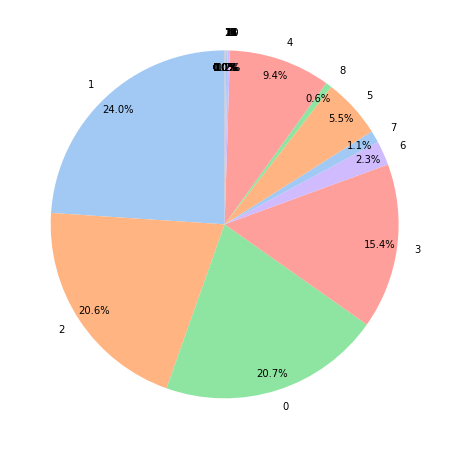

In [26]:
num_prefix = []
for i in ls_replacement:
  num_prefix.append(len(i))
# num_prefix
num_prefix = np.array(num_prefix)
counts = Counter(num_prefix)
fig1, ax1 = plt.subplots(figsize=(8, 8))
colors = sns.color_palette('pastel')[0:5]
# counts = counts[0:9]
ax1.pie(counts.values(), labels=counts.keys(), colors = colors, autopct='%1.1f%%',pctdistance=0.9,
        shadow=False, startangle=90)


In [21]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# fig1, ax1 = plt.subplots()
# colors = sns.color_palette('pastel')[0:5]
# ax1.pie(counts.values(), labels=counts.keys(),'%1.1f%%')
15.4+20.7+20.6+25

81.7

In [29]:
type(counts)

collections.Counter

In [31]:
counts[0]=0
counts

Counter({1: 24103,
         2: 20754,
         0: 0,
         3: 15462,
         6: 2277,
         7: 1117,
         5: 5570,
         8: 575,
         4: 9493,
         9: 229,
         10: 126,
         11: 63,
         13: 14,
         12: 29,
         16: 5,
         17: 5,
         19: 5,
         15: 6,
         14: 12,
         21: 1,
         18: 1})